In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.inspection import inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
Station = Base.classes.station
Measurement = Base.classes.measurement



C:\Users\adibt\AppData\Local\Temp\ipykernel_42908\2592821084.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
for name, cls in Base.classes.items():
    print(name)

measurement
station


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station= Base.classes.station


In [8]:

# Create our session (link) from Python to the DB
session = sqlalchemy.orm.Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
inspector = inspect(engine)

columns_station = inspector.get_columns('station')
for column in columns_station:
    print(column["name"], column["type"])



id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
inspector = inspect(engine)

columns_station = inspector.get_columns('measurement')
for column in columns_station:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
tables = inspector.get_table_names()
tables

['measurement', 'station']

In [15]:
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date = dt.datetime(2017, 8, 23)

# Calculate the date one year from the last date in data set.
start_date = end_date - dt.timedelta(days=365)

print(end_date)
print(start_date)

2017-08-23 00:00:00
2016-08-23 00:00:00


In [17]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
precipitation_df = precipitation_df.dropna()

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')
precipitation_df.head()

,Date,Precipitation
0,2016-08-24,0.08
1188,2016-08-24,1.22
702,2016-08-24,2.28
1875,2016-08-24,1.45
360,2016-08-24,2.15


In [12]:
# Old code errors 
# # Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# # Starting from the most recent data point in the database. 
# # Calculate the date one year from the last date in data set.
# one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
# one_year_ago

# # Perform a query to retrieve the data and precipitation scores
# one_year_ago_datetime = one_year_ago.to_pydatetime()

# precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago_datetime).filter(Measurement.prcp != None).all()
# print(precipitation_data)


[]


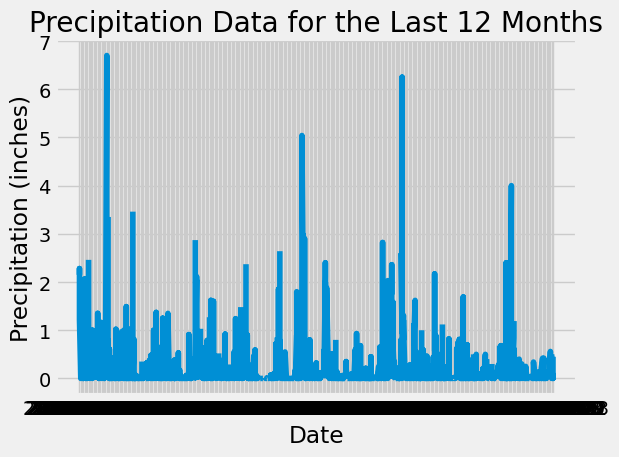

In [18]:

# Use Pandas Plotting with Matplotlib to plot the data
measurements_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
measurements_df= measurements_df.sort_values(by='date')
plt.plot(measurements_df['date'], measurements_df['precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data for the Last 12 Months')
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
measurements_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(func.count((Station.station))).scalar()

# Print the result
print(f"Total number of stations: {num_stations}")

Total number of stations: 9


In [23]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Print the stations and their counts in descending order
for station, count in station_counts:
    print(f"Station {station}: {count}")

Station USC00519281: 2772
Station USC00519397: 2724
Station USC00513117: 2709
Station USC00519523: 2669
Station USC00516128: 2612
Station USC00514830: 2202
Station USC00511918: 1979
Station USC00517948: 1372
Station USC00518838: 511


In [24]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_counts[0][0]
temperature_stats = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station).all()

# Print the temperature statistics
print(f"Lowest temperature: {temperature_stats[0][0]}")
print(f"Average temperature: {temperature_stats[0][1]}")
print(f"Highest temperature: {temperature_stats[0][2]}")

Lowest temperature: 54.0
Average temperature: 71.66378066378067
Highest temperature: 85.0


Text(0, 0.5, 'Frequency')

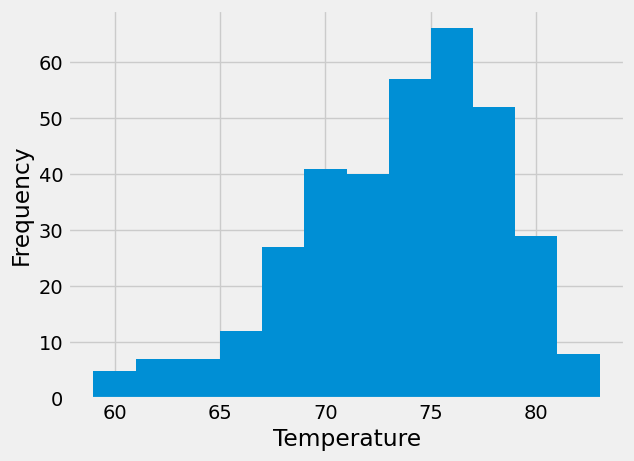

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= start_date).all()

temp_results_df = pd.DataFrame(temp_results)['tobs']

hist = temp_results_df.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')

In [ ]:
#old code with errors 
# # Using the most active station id
# # Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# from datetime import timedelta
# # Get the most active station id
# most_active_station = station_counts[0][0]

# # Get the most recent date in the database
# most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# # Calculate the start date for the last 12 months
# start_date = one_year_ago_datetime.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=365)

# # Design a query to retrieve the temperature data for the last 12 months
# temperature_data = session.query(Measurement.tobs).\
#                    filter(Measurement.station == most_active_station, Measurement.date >= start_date).all()

# # Convert the temperature data to a list of numbers
# temperature_list = [t[0] for t in temperature_data]

# # Create a histogram of the temperature data
# plt.hist(temperature_list, bins=10)
# plt.xlabel('Temperature (°F)')
# plt.ylabel('Frequency')
# plt.title(f'Temperature Distribution for Station {most_active_station}')
# plt.show()

# Close Session

In [ ]:
# Close Session
session.close()